In [52]:
import random
import pickle
import numpy as np
from datasets import load_dataset, concatenate_datasets
import os
from chatgpt_eval import get_chatgpt_eval_news, get_chatgpt_eval_lfqa, get_chatgpt_eval_recipe


def shuffle_two_lists(l1, l2, indices=None, random_seed=42):
    random.seed(random_seed)
    if not indices:
        indices = list(range(len(l1)))
        random.shuffle(indices)    
    if len(indices) != len(l1):
        raise ValueError("The length of indices should be the same as the length of the lists")
    if len(l1) != len(l2):
        raise ValueError("The length of the two lists should be the same")
    shuffled_list1 = [l1[i] for i in indices]
    shuffled_list2 = [l2[i] for i in indices]
    return shuffled_list1, shuffled_list2

# def add_shuffled_v1(datapoint):
#     sents, labels = datapoint['output_sentences'], datapoint['discourse']
#     shuffled_sents, shuffled_labels = shuffle_two_lists(sents, labels, random_seed=43)
#     datapoint['output_sentences_v1'] = shuffled_sents
#     datapoint['output_v1'] = ' '.join(shuffled_sents)
#     datapoint['discourse_v1'] = shuffled_labels
#     return datapoint
def add_shuffled_v1(datapoint):
    sents, labels = datapoint['output_sentences'], datapoint['discourse']
    random.seed(None)
    # random_shuffle_bin_number = random.randint(1, 2)
    # random_shuffle_bin_number = min(len(labels), random_shuffle_bin_number)
    random_shuffle_bin_number = random.randint(1, int(len(labels)/2))
    random_shuffle_bin_number = max(2, random_shuffle_bin_number)
    random_shuffle_bin_number = min(6, random_shuffle_bin_number)
    # print(random_shuffle_bin_number)
    sents_len = len(sents)
    bin_cnt, bin_values = np.histogram(range(sents_len), bins=random_shuffle_bin_number)
    bin_with_idx = [[] for _ in range(random_shuffle_bin_number)]
    for idx in range(sents_len):
        bin_idx = np.digitize(idx, bin_values[:-1])-1
        bin_with_idx[bin_idx].append(idx)
    shuffled_indices = []
    for bin in bin_with_idx:
        random.shuffle(bin)
        shuffled_indices += bin
    shuffled_sents, shuffled_labels = shuffle_two_lists(sents, labels, shuffled_indices, random_seed=51)
    datapoint['output_sentences_v1'] = shuffled_sents
    datapoint['output_v1'] = ' '.join(shuffled_sents)
    datapoint['discourse_v1'] = shuffled_labels
    return datapoint


def add_shuffled_v2(datapoint):
    sents, labels = datapoint['output_sentences'], datapoint['discourse']
    random.seed(None)
    # random_shuffle_bin_number = random.randint(1, 2)
    # random_shuffle_bin_number = min(len(labels), random_shuffle_bin_number)
    random_shuffle_bin_number = random.randint(1, int(len(labels)/2))
    random_shuffle_bin_number = max(2, random_shuffle_bin_number)
    random_shuffle_bin_number = min(6, random_shuffle_bin_number)
    # print(random_shuffle_bin_number)
    sents_len = len(sents)
    bin_cnt, bin_values = np.histogram(range(sents_len), bins=random_shuffle_bin_number)
    bin_with_idx = [[] for _ in range(random_shuffle_bin_number)]
    for idx in range(sents_len):
        bin_idx = np.digitize(idx, bin_values[:-1])-1
        bin_with_idx[bin_idx].append(idx)
    shuffled_indices = []
    for bin in bin_with_idx:
        random.shuffle(bin)
        shuffled_indices += bin
    shuffled_sents, shuffled_labels = shuffle_two_lists(sents, labels, shuffled_indices, random_seed=32)
    datapoint['output_sentences_v2'] = shuffled_sents
    datapoint['output_v2'] = ' '.join(shuffled_sents)
    datapoint['discourse_v2'] = shuffled_labels
    return datapoint

def shuffle_variation(datapoint):
    variations = [datapoint['output_v1'], datapoint['output_v2']]
    indice = list(range(len(variations)))
    random.shuffle(indice)
    variations = [variations[i] for i in indice]
    datapoint['output_shuffled_1'] = variations[0]
    datapoint['output_shuffled_2'] = variations[1]
    datapoint['random_indice'] = indice
    return datapoint


In [46]:
from metrics import calculate_positional_divergence
from sklearn.metrics import cohen_kappa_score
from collections import Counter
from evaluate import load
import evaluate


def get_kappa_with_gpt(data, num_class, N):
    human_preference = []
    for row in data['gpt_scores']:
        if row[0] > row[1]:
            human_preference.append(1)
        elif row[0] == row[1]:
            human_preference.append(0)
        else:
            human_preference.append(2)
    print("GPT score ratio: ",Counter(human_preference))

    pdd_kappa_list = []
    for bin_num in range(1,N):
        pd_preference = []
        pdd_1, pdd_2 = [], []
        for d0, d1, d2, r in zip(data['discourse'], data['discourse_v1'], data['discourse_v2'], data['random_indice']):
            pd1 = calculate_positional_divergence(
                predictions=[d1],
                references=[d0],
                num_class=num_class,
                num_bins_default=bin_num,
                return_normalized_score=True, 
                return_tensor=False
                )
            pd2 = calculate_positional_divergence(
                predictions=[d2],
                references=[d0],
                num_class=num_class,
                num_bins_default=bin_num,
                return_normalized_score=True, 
                return_tensor=False
                )
            # print(pd1,pd2)
            if r[0] == 0:
                if pd1 > pd2:
                    pd_preference.append(1)
                elif pd1 == pd2:
                    pd_preference.append(0)
                else:
                    pd_preference.append(2)
            else:
                if pd1 > pd2:
                    pd_preference.append(2)
                elif pd1 == pd2:
                    pd_preference.append(0)
                else:
                    pd_preference.append(1)

        pd_corr = cohen_kappa_score(human_preference, pd_preference)
        pdd_kappa_list.append(pd_corr)

    # Exact match preference
    from metrics import exact_match
    exact_match_preference = []
    for d0, d1, d2, r in zip(data['discourse'], data['discourse_v1'], data['discourse_v2'], data['random_indice']):
        acc1 = exact_match(preds=d1, refs=d0)
        acc2 = exact_match(preds=d2, refs=d0)
        if r[0] == 0:
            if acc1 > acc2:
                exact_match_preference.append(1)
            elif acc1 == acc2:
                exact_match_preference.append(0)
            else:
                exact_match_preference.append(2)
        else:
            if acc1 > acc2:
                exact_match_preference.append(2)
            elif acc1 == acc2:
                exact_match_preference.append(0)
            else:
                exact_match_preference.append(1)
    pd_corr = cohen_kappa_score(human_preference, pd_preference)
    acc_corr = cohen_kappa_score(human_preference, exact_match_preference)
    print('acc kappa: ', acc_corr)

    # bertscore
    bertscore = load("bertscore")
    bertscore1 = bertscore.compute(predictions=data['output_v1'], references=data['output'], lang="en")['precision']
    bertscore2 = bertscore.compute(predictions=data['output_v2'], references=data['output'], lang="en")['precision']

    bertscore_preference = []
    for bs1, bs2, r in zip(bertscore1, bertscore2, data['random_indice']):
        if r[0] == 0:
            if bs1 > bs2:
                bertscore_preference.append(1)
            elif bs1 == bs2:
                bertscore_preference.append(0)
            else:
                bertscore_preference.append(2)
        else:
            if bs1 > bs2:
                bertscore_preference.append(2)
            elif bs1 == bs2:
                bertscore_preference.append(0)
            else:
                bertscore_preference.append(1)
    bert_kappa = cohen_kappa_score(human_preference, bertscore_preference)
    print('bertscore kappa: ', bert_kappa)

    # BLEU score
    bleu = load("google_bleu")
    bleu_preference = []
    for t0, t1, t2, r in zip(data['output'], data['output_v1'], data['output_v2'], data['random_indice']):
        bs1 = bleu.compute(predictions=[t1], references=[t0])
        bs2 = bleu.compute(predictions=[t2], references=[t0])
        if r[0] == 0:
            if bs1['google_bleu'] > bs2['google_bleu']:
                bleu_preference.append(1)
            elif bs1['google_bleu'] == bs2['google_bleu']:
                bleu_preference.append(0)
            else:
                bleu_preference.append(2)
        else:
            if bs1['google_bleu'] > bs2['google_bleu']:
                bleu_preference.append(2)
            elif bs1['google_bleu'] == bs2['google_bleu']:
                bleu_preference.append(0)
            else:
                bleu_preference.append(1)
    bleu_kappa = cohen_kappa_score(human_preference, bleu_preference)
    print('bleu kappa: ', bleu_kappa)

    # ROUGE score
    rouge = load("rouge")
    rouge_preference = []
    for t0, t1, t2, r in zip(data['output'], data['output_v1'], data['output_v2'], data['random_indice']):
        rouge1 = rouge.compute(predictions=[t1], references=[t0])['rouge2']
        rouge2 = rouge.compute(predictions=[t2], references=[t0])['rouge2']
        if r[0] == 0:
            if rouge1 > rouge2:
                rouge_preference.append(1)
            elif rouge1 == rouge2:
                rouge_preference.append(0)
            else:
                rouge_preference.append(2)
        else:
            if rouge1 > rouge2:
                rouge_preference.append(2)
            elif rouge1 == rouge2:
                rouge_preference.append(0)
            else:
                rouge_preference.append(1)
    rouge_kappa = cohen_kappa_score(human_preference, rouge_preference)
    print('rouge kappa: ', rouge_kappa)

    return pdd_kappa_list, acc_corr, bert_kappa, bleu_kappa, rouge_kappa


# News data

In [53]:
from datasets import load_dataset, concatenate_datasets
import os
news_data_path = '/home/yinhong/Documents/source/discourse_rl/data/news_discourse_preprocessed'
data_files = ['train_data.jsonl', 'valid_data.jsonl', 'test_data.jsonl']

def load_news_data(data_files):
    data = []
    for file in data_files:
        data.append(load_dataset('json', data_files=os.path.join(news_data_path, file))['train'])
    data = concatenate_datasets(data)
    return data

news_data = load_news_data(data_files)

def custom_filter(example):
    # filter too long examples
    discourse_len = len(example['discourse'])
    if discourse_len < 40 and discourse_len > 5:
        return True
    else:
        return False

news_data = news_data.filter(custom_filter)
selected_data = news_data.shuffle().select(range(300))

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

In [54]:
def add_smooth_v0(datapoint):
    datapoint['output_v0'] = datapoint['output'].replace('\n', ' ')
    return datapoint

selected_data = selected_data.map(add_smooth_v0)
selected_data = selected_data.map(add_shuffled_v1)
selected_data = selected_data.map(add_shuffled_v2)
selected_data = selected_data.add_column("index", range(len(selected_data)))
selected_data = selected_data.map(shuffle_variation)


Map:   0%|          | 0/300 [00:00<?, ? examples/s]

Map:   0%|          | 0/300 [00:00<?, ? examples/s]

Map:   0%|          | 0/300 [00:00<?, ? examples/s]

Map:   0%|          | 0/300 [00:00<?, ? examples/s]

In [55]:
from chatgpt_eval import get_chatgpt_eval_news
from openai_utils import call_openai_chat_completion
from jinja2 import Environment
from textwrap import dedent
import json
import ast
from tqdm import tqdm
from datasets import load_dataset

selected_data = get_chatgpt_eval_news(selected_data, engine='gpt-4')

def filter_nan(datapoint):
    for k, v in datapoint.items():
        if v == None:
            return False
    return True

selected_data = selected_data.filter(filter_nan)

100%|██████████| 300/300 [10:23<00:00,  2.08s/it]


Filter:   0%|          | 0/300 [00:00<?, ? examples/s]

In [10]:
selected_data.to_json("news_annotations.jsonl", orient="records", lines=True, index=False)

Creating json from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

8141276

In [ ]:
news_data = load_dataset('json', data_files="news_annotations.jsonl")['train']

In [56]:
news_pd_kappa_list, news_acc_corr, news_bertscore_kappa, news_bleu_kappa, news_rouge_kappa = \
    get_kappa_with_gpt(selected_data, num_class=8, N=40)

GPT score ratio:  Counter({1: 218, 2: 76, 0: 6})
acc kappa:  0.16403601075645968


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


bertscore kappa:  0.3408744833587122
bleu kappa:  0.19419146346581606
rouge kappa:  0.1571389550083896


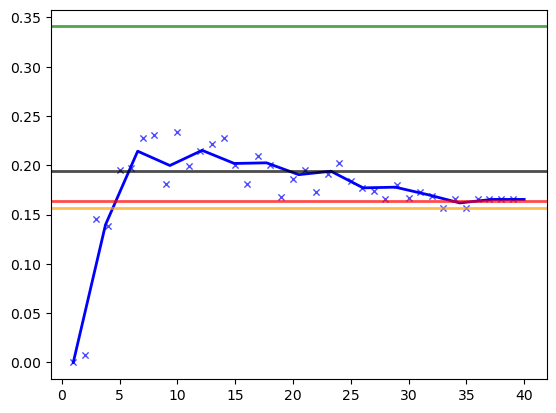

In [57]:
import matplotlib.pyplot as plt
import numpy as np

N=40

x = np.array(range(1,N))
y = np.array(news_pd_kappa_list) 
# y[0]=0.001

smooth_x = np.linspace(1, N, 15)  # Adjust the range and number of points as needed
smooth_y = np.interp(smooth_x, x, y)  # Use interpolation to get smooth values


plt.scatter(x, y, marker='x', color='blue', alpha=0.7, s=20, lw=1)
plt.plot(smooth_x, smooth_y, label='Smooth Curve', color='blue', lw=2)
plt.axhline(y=news_acc_corr, color='r', linestyle='-',alpha=0.7, lw=2)
plt.axhline(y=news_bertscore_kappa, color='g', linestyle='-',alpha=0.7, lw=2)
plt.axhline(y=news_bleu_kappa, color='black', linestyle='-', alpha=0.7, lw=2)
plt.axhline(y=news_rouge_kappa, color='orange', linestyle='-', alpha=0.7, lw=2)


In [ ]:
from evaluate import load
bertscore = load("bertscore")

bertscore_preference = []
for t0, t1, t2 in zip(selected_data['output_v0'], selected_data['output_v1'], selected_data['output_v2']):
    bs1 = bertscore.compute(predictions=[t1], references=[t0], lang="en")
    bs2 = bertscore.compute(predictions=[t2], references=[t0], lang="en")
    if bs1['f1'] > bs2['f1']:
        bertscore_preference.append(1)
    else:
        bertscore_preference.append(2)

bert_corr = cohen_kappa_score(human_preference, bertscore_preference)
print('bertscore kappa: ', bert_corr)

# LFQA

In [11]:
from datasets import load_dataset
data_path = '/home/yinhong/Documents/source/lfqa_discourse/data/role_annotation.jsonl'
data = load_dataset('json', data_files=data_path)['train']

def filter_model_answer(datapoint):
    if datapoint['dataset'] == 'ELI5_MODEL':
        return False
    return True

filtered_data = data.filter(filter_model_answer)
filtered_data = filtered_data.shuffle().select(range(300))

  0%|          | 0/1 [00:00<?, ?it/s]

In [12]:
# get unique role
from collections import Counter
unique_role = set()
role_buf = []
for datapoint in filtered_data:
    role_buf += datapoint['role_annotation']

id2unique_role = list(set(role_buf))
role2id = {role: idx for idx, role in enumerate(id2unique_role)}

# convert role annotation to id
def convert_role_to_id(datapoint):
    role_annotation = datapoint['role_annotation']
    role_ids = [role2id[role] for role in role_annotation]
    datapoint['role_ids'] = role_ids
    return datapoint

filtered_data = filtered_data.map(convert_role_to_id)
filtered_data = filtered_data.rename_column('question', 'input')
filtered_data = filtered_data.rename_column('answer_paragraph', 'output')
filtered_data = filtered_data.rename_column('answer_sentences', 'output_sentences')
filtered_data = filtered_data.rename_column('role_ids', 'discourse')
lfqa_data = filtered_data

Map:   0%|          | 0/300 [00:00<?, ? examples/s]

In [13]:
lfqa_data = lfqa_data.map(add_shuffled_v1)
lfqa_data = lfqa_data.map(add_shuffled_v2)
lfqa_data = lfqa_data.map(shuffle_variation)


Map:   0%|          | 0/300 [00:00<?, ? examples/s]

Map:   0%|          | 0/300 [00:00<?, ? examples/s]

2
2
2
3
2
2
2
3
3
2
2
2
2
2
2
3
2
2
2
2
2
2
2
2
2
4
2
3
2
2
3
2
3
2
2
2
2
2
2
2
2
2
2
3
2
2
2
2
2
2
3
3
2
3
2
2
3
2
2
2
3
2
2
4
2
2
2
3
2
3
5
2
2
2
2
2
3
2
2
2
2
5
2
2
2
5
2
2
6
2
2
2
3
4
2
2
2
2
4
3
2
2
2
2
3
2
2
3
2
2
2
2
3
2
2
2
2
2
2
3
2
2
2
2
3
2
4
2
2
2
2
2
5
2
2
2
2
2
2
2
2
2
2
6
2
2
2
2
2
3
2
2
5
3
2
3
2
2
2
2
2
3
2
2
2
2
4
5
4
2
2
2
4
2
2
2
3
2
2
2
6
2
2
2
2
3
2
2
2
2
2
2
5
2
2
2
6
2
3
2
2
6
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
4
3
4
2
2
2
2
2
2
3
2
2
3
2
2
2
2
4
3
2
2
2
2
2
2
2
2
2
4
2
6
2
2
3
2
2
3
3
2
2
2
2
2
2
2
2
2
5
5
2
2
3
2
2
2
2
2
3
3
6
2
2
2
2
4
2
2
2
3
2
5
2
2
2
2
2
2
2


Map:   0%|          | 0/300 [00:00<?, ? examples/s]

In [14]:
from chatgpt_eval import get_chatgpt_eval_lfqa
from openai_utils import call_openai_chat_completion
from jinja2 import Environment
from textwrap import dedent
import json
import ast
from tqdm import tqdm
from datasets import load_dataset

lfqa_data = get_chatgpt_eval_lfqa(lfqa_data, engine='gpt-4')

def filter_nan(datapoint):
    for k, v in datapoint.items():
        if v == None:
            return False
    return True

lfqa_data = lfqa_data.filter(filter_nan)

100%|██████████| 300/300 [10:11<00:00,  2.04s/it]


Filter:   0%|          | 0/300 [00:00<?, ? examples/s]

In [24]:

lfqa_data.to_json("lfqa_annotations.jsonl", orient="records", lines=True, index=False)

Creating json from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

1979418

In [14]:
data = load_dataset('json', data_files="lfqa_annotations.jsonl")['train']


Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Dataset json downloaded and prepared to /home/yinhong/.cache/huggingface/datasets/json/default-ab4716f91e4f6c45/0.0.0/e347ab1c932092252e717ff3f949105a4dd28b27e842dd53157d2f72e276c2e4. Subsequent calls will reuse this data.


  0%|          | 0/1 [00:00<?, ?it/s]

In [15]:
lfqa_pd_kappa_list, lfqa_acc_corr, lfqa_bertscore_kappa, lfqa_bleu_kappa, lfqa_rouge_kappa = \
    get_kappa_with_gpt(lfqa_data, num_class=6, N=20)

GPT score ratio:  Counter({1: 237, 2: 61, 0: 2})
acc kappa:  0.23510778026732604


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


bertscore kappa:  0.4257166868988701
bleu kappa:  0.3205745531706521
rouge kappa:  0.1866873561988336


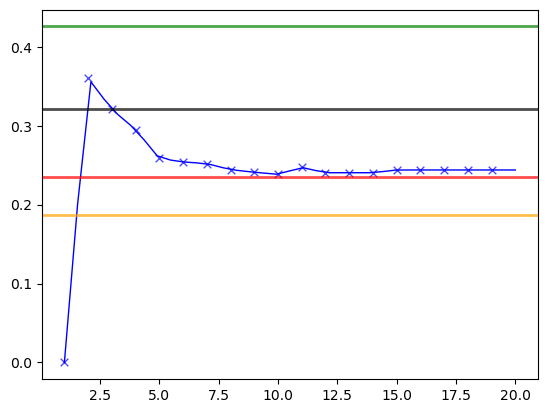

In [23]:
import matplotlib.pyplot as plt
import numpy as np

N=20

x = np.array(range(1,N))
y = np.array(lfqa_pd_kappa_list) 
# y[0]=0.001

smooth_x = np.linspace(1, N, 35)  # Adjust the range and number of points as needed
smooth_y = np.interp(smooth_x, x, y)  # Use interpolation to get smooth values


plt.scatter(x, y, marker='x', color='blue', alpha=0.7, s=30, lw=1)
plt.plot(smooth_x, smooth_y, label='Smooth Curve', color='blue', lw=1)
plt.axhline(y=lfqa_acc_corr, color='r', linestyle='-',alpha=0.7, lw=2)
plt.axhline(y=lfqa_bertscore_kappa, color='g', linestyle='-',alpha=0.7, lw=2)
plt.axhline(y=lfqa_bleu_kappa, color='black', linestyle='-', alpha=0.7, lw=2)
plt.axhline(y=lfqa_rouge_kappa, color='orange', linestyle='-', alpha=0.7, lw=2)


# Recipes

In [106]:
import json
data_path = '/home/yinhong/Documents/datasets/recipe1m+/preprocessed_data/train_dataset.json'

with open(data_path, 'r') as f:
    data = json.load(f)
    
# convert to dataset
from datasets import Dataset
data = Dataset.from_dict(data)

data = data.shuffle().select(range(200))

def process_recipe(datapoint):
    title_token_start = '<TITLE_START>'
    title_token_end = '<TITLE_END>'
    ingredient_token_start = '<INGR_START>'
    ingredient_token_sep = '<INGR_NEXT>'
    ingredient_token_end = '<INGR_END>'
    instruction_token_start = '<INSTR_START>'
    instruction_token_sep = '<INSTR_NEXT>'
    instruction_token_end = '<INSTR_END>'
    title = datapoint['text'].split(title_token_start)[1].split(title_token_end)[0].strip()
    ingredients = datapoint['text'].split(ingredient_token_start)[1].split(ingredient_token_end)[0].split(ingredient_token_sep)
    ingredients = [ingr.strip() for ingr in ingredients]
    ingredients = [ingr[0].upper() + ingr[1:] for ingr in ingredients]
    instructions = datapoint['text'].split(instruction_token_start)[1].split(instruction_token_end)[0].split(instruction_token_sep)
    instructions = [instr.strip() for instr in instructions]
    instructions = [instr[0].upper() + instr[1:] for instr in instructions]
    datapoint['title'] = title
    datapoint['ingredients'] = ingredients
    datapoint['instructions'] = instructions
    datapoint['output'] = ' '.join(instructions)
    return datapoint

data = data.map(process_recipe)


Map:   0%|          | 0/200 [00:00<?, ? examples/s]

In [107]:
data = data.rename_column('title', 'input')
# data = data.rename_column('answer_paragraph', 'output')
data = data.rename_column('stage_label', 'discourse')
data = data.rename_column('instructions', 'output_sentences')
recipe_data = data

In [108]:

recipe_data = recipe_data.map(add_shuffled_v1)
recipe_data = recipe_data.map(add_shuffled_v2)
recipe_data = recipe_data.map(shuffle_variation)
recipe_data = recipe_data.add_column("index", range(len(recipe_data)))



Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

2
5
2
2
2
4
5
2
2
2
5
5
2
3
2
2
2
2
3
4
3
4
2
3
2
4
5
2
2
3
2
2
2
2
2
2
2
5
5
3
3
2
3
2
3
3
2
2
2
2
2
2
2
2
2
2
2
2
3
2
2
2
2
2
2
2
3
2
3
2
4
2
2
2
4
2
2
5
2
2
2
3
2
4
3
2
3
2
2
3
2
2
2
3
3
2
2
2
2
2
2
2
2
2
2
3
2
2
2
5
5
4
2
2
2
4
2
2
2
3
2
4
2
3
5
3
2
2
2
4
2
2
2
2
2
2
3
2
2
4
2
3
2
2
3
3
2
5
2
2
2
5
4
5
2
4
5
2
2
2
2
2
3
3
3
2
3
2
4
2
2
3
2
2
2
2
5
2
2
3
2
2
4
5
2
5
3
3
3
2
3
2
2
3
5
2
3
3
3
4


Map:   0%|          | 0/200 [00:00<?, ? examples/s]

In [109]:
from chatgpt_eval import get_chatgpt_eval_recipe
from openai_utils import call_openai_chat_completion
from jinja2 import Environment
from textwrap import dedent
import json
import ast
from tqdm import tqdm
from datasets import load_dataset

recipe_data = get_chatgpt_eval_recipe(recipe_data, engine='gpt-4')

def filter_nan(datapoint):
    for k, v in datapoint.items():
        if v == None:
            return False
    return True

recipe_data = recipe_data.filter(filter_nan)

100%|██████████| 200/200 [07:02<00:00,  2.11s/it]


Filter:   0%|          | 0/200 [00:00<?, ? examples/s]

In [112]:

recipe_data.to_json("recipe_annotations.jsonl", orient="records", lines=True, index=False)

Creating json from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

1187181

In [ ]:
recipe_data = load_dataset('json', data_files="recipe_annotations.jsonl")['train']


In [110]:
from metrics import calculate_positional_divergence
from sklearn.metrics import cohen_kappa_score
from collections import Counter
from evaluate import load


def get_kappa_with_gpt(data, num_class, N):
    human_preference = []
    for row in data['gpt_scores']:
        if row[0] > row[1]:
            human_preference.append(1)
        elif row[0] == row[1]:
            human_preference.append(0)
        else:
            human_preference.append(2)
    print("GPT score ratio: ",Counter(human_preference))

    pdd_kappa_list = []
    for bin_num in range(1,N):
        pd_preference = []
        pdd_1, pdd_2 = [], []
        for d0, d1, d2, r in zip(data['discourse'], data['discourse_v1'], data['discourse_v2'], data['random_indice']):
            pd1 = calculate_positional_divergence(
                predictions=[d1],
                references=[d0],
                num_class=num_class,
                num_bins_default=bin_num,
                return_normalized_score=True, 
                return_tensor=False
                )
            pd2 = calculate_positional_divergence(
                predictions=[d2],
                references=[d0],
                num_class=num_class,
                num_bins_default=bin_num,
                return_normalized_score=True, 
                return_tensor=False
                )
            # print(pd1,pd2)
            if r[0] == 0:
                if pd1 > pd2:
                    pd_preference.append(1)
                elif pd1 == pd2:
                    pd_preference.append(0)
                else:
                    pd_preference.append(2)
            else:
                if pd1 > pd2:
                    pd_preference.append(2)
                elif pd1 == pd2:
                    pd_preference.append(0)
                else:
                    pd_preference.append(1)

        pd_corr = cohen_kappa_score(human_preference, pd_preference)
        pdd_kappa_list.append(pd_corr)

    # Exact match preference
    from metrics import exact_match
    exact_match_preference = []
    for d0, d1, d2, r in zip(data['discourse'], data['discourse_v1'], data['discourse_v2'], data['random_indice']):
        acc1 = exact_match(preds=d1, refs=d0)
        acc2 = exact_match(preds=d2, refs=d0)
        if r[0] == 0:
            if acc1 > acc2:
                exact_match_preference.append(1)
            elif acc1 == acc2:
                exact_match_preference.append(0)
            else:
                exact_match_preference.append(2)
        else:
            if acc1 > acc2:
                exact_match_preference.append(2)
            elif acc1 == acc2:
                exact_match_preference.append(0)
            else:
                exact_match_preference.append(1)


    pd_corr = cohen_kappa_score(human_preference, pd_preference)
    acc_corr = cohen_kappa_score(human_preference, exact_match_preference)
    print('acc kappa: ', acc_corr)

    bert_kappa=0

    return pdd_kappa_list, acc_corr, bert_kappa

recipe_pd_kappa_list, recipe_acc_corr, recipe_bertscore_kappa = get_kappa_with_gpt(recipe_data, num_class=7, N=15)

GPT score ratio:  Counter({1: 135, 2: 55, 0: 10})
acc kappa:  0.2534722222222221


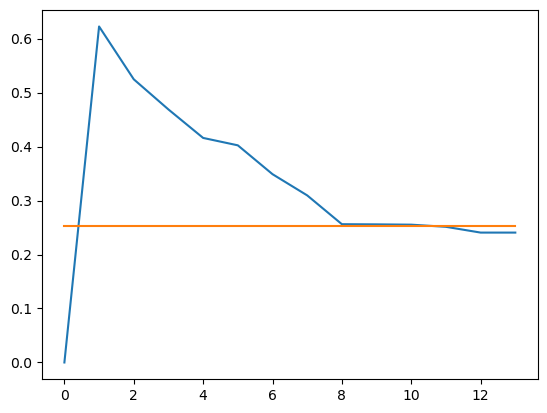

In [111]:
import matplotlib.pyplot as plt

plt.plot(recipe_pd_kappa_list)
plt.plot([recipe_acc_corr]*14)

# Plot

In [26]:
from datasets import load_dataset
news_data = load_dataset('json', data_files="news_annotations.jsonl")['train']
lfqa_data = load_dataset('json', data_files="lfqa_annotations.jsonl")['train']
recipe_data = load_dataset('json', data_files="recipe_annotations.jsonl")['train']


Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Dataset json downloaded and prepared to /home/yinhong/.cache/huggingface/datasets/json/default-5908e50e4c866daa/0.0.0/e347ab1c932092252e717ff3f949105a4dd28b27e842dd53157d2f72e276c2e4. Subsequent calls will reuse this data.


  0%|          | 0/1 [00:00<?, ?it/s]

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Dataset json downloaded and prepared to /home/yinhong/.cache/huggingface/datasets/json/default-2d4c8d2958ef43a4/0.0.0/e347ab1c932092252e717ff3f949105a4dd28b27e842dd53157d2f72e276c2e4. Subsequent calls will reuse this data.


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

In [42]:

news_pd_kappa_list, news_acc_corr, news_bertscore_kappa, news_bleu_kappa, news_rouge_kappa = \
    get_kappa_with_gpt(news_data, num_class=8, N=30)
lfqa_pd_kappa_list, lfqa_acc_corr, lfqa_bertscore_kappa, lfqa_bleu_kappa, lfqa_rouge_kappa = \
    get_kappa_with_gpt(lfqa_data, num_class=6, N=10)
recipe_pd_kappa_list, recipe_acc_corr, recipe_bertscore_kappa, recipe_bleu_kappa, recipe_rouge_kappa = \
    get_kappa_with_gpt(recipe_data, num_class=7, N=10)

GPT score ratio:  Counter({1: 221, 2: 79})
acc kappa:  0.4336222431991762


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


bertscore kappa:  0.6312231100184389
bleu kappa:  0.48632482535044064
rouge kappa:  0.4508500252482748
GPT score ratio:  Counter({1: 237, 2: 61, 0: 2})
acc kappa:  0.23510778026732604


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


bertscore kappa:  0.4257166868988701
bleu kappa:  0.3205745531706521
rouge kappa:  0.1866873561988336
GPT score ratio:  Counter({1: 135, 2: 55, 0: 10})
acc kappa:  0.2534722222222221


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


bertscore kappa:  0.7137014314928425
bleu kappa:  0.3200626258107806
rouge kappa:  0.2329430763019783


In [93]:
from metrics import calculate_positional_divergence
from sklearn.metrics import cohen_kappa_score
from collections import Counter
from evaluate import load


def get_kappa_with_gpt(data, num_class, N):
    # human preference
    human_preference = []
    for row in data['gpt_scores_unshuffled']:
        if row[0] > row[1]:
            human_preference.append(1)
        else:
            human_preference.append(2)
    print("GPT score ratio: ",Counter(human_preference))


    # pd preference
    pd_kappa_list = []
    for bin_num in range(1,N):
        pd_preference = []
        for d0, d1, d2 in zip(data['discourse'], data['discourse_v1'], data['discourse_v2']):
            pd1 = calculate_positional_divergence(
                predictions=[d1],
                references=[d0],
                num_class=num_class,
                num_bins_default=bin_num,
                return_normalized_score=True, 
                return_tensor=False
                )
            pd2 = calculate_positional_divergence(
                predictions=[d2],
                references=[d0],
                num_class=num_class,
                num_bins_default=bin_num,
                return_normalized_score=True, 
                return_tensor=False
                )
            # print(pd1,pd2)
            if pd1 > pd2:
                pd_preference.append(1)
            else:
                pd_preference.append(2)
        
        pd_corr = cohen_kappa_score(human_preference, pd_preference)
        pd_kappa_list.append(pd_corr)
        # print('bin: {}, pd kappa: {}'.format(bin_num,  pd_corr))
        print("PDD score ratio: ",Counter(pd_preference))

    # Exact match preference
    from metrics import exact_match
    exact_match_preference = []
    for d0, d1, d2 in zip(data['discourse'], data['discourse_v1'], data['discourse_v2']):
        acc1 = exact_match(preds=d1, refs=d0)
        acc2 = exact_match(preds=d2, refs=d0)
        if acc1 > acc2:
            exact_match_preference.append(1)
        else:
            exact_match_preference.append(2)
    print("Acc score ratio: ",Counter(exact_match_preference))


    pd_corr = cohen_kappa_score(human_preference, pd_preference)
    acc_corr = cohen_kappa_score(human_preference, exact_match_preference)
    print('pd kappa: ', pd_corr)
    print('acc kappa: ', acc_corr)


    bertscore = load("bertscore")
    bertscore_preference = []
    for t0, t1, t2 in zip(data['output'], data['output_v1'], data['output_v2']):
        bs1 = bertscore.compute(predictions=[t1], references=[t0], lang="en")
        bs2 = bertscore.compute(predictions=[t2], references=[t0], lang="en")
        if bs1['f1'] > bs2['f1']:
            bertscore_preference.append(1)
        else:
            bertscore_preference.append(2)

    bert_kappa = cohen_kappa_score(human_preference, bertscore_preference)
    print('bertscore kappa: ', bert_kappa)

    return pd_kappa_list, acc_corr, bert_kappa

news_pd_kappa_list, news_acc_corr, news_bertscore_kappa = get_kappa_with_gpt(news_data, num_class=8, N=40)
lfqa_pd_kappa_list, lfqa_acc_corr, lfqa_bertscore_kappa = get_kappa_with_gpt(lfqa_data, num_class=6, N=20)

GPT score ratio:  Counter({2: 115, 1: 85})
PDD score ratio:  Counter({2: 200})
PDD score ratio:  Counter({2: 154, 1: 46})
PDD score ratio:  Counter({2: 134, 1: 66})
PDD score ratio:  Counter({2: 131, 1: 69})
PDD score ratio:  Counter({2: 123, 1: 77})
PDD score ratio:  Counter({2: 119, 1: 81})
PDD score ratio:  Counter({2: 113, 1: 87})
PDD score ratio:  Counter({2: 116, 1: 84})
PDD score ratio:  Counter({2: 121, 1: 79})
PDD score ratio:  Counter({2: 117, 1: 83})
PDD score ratio:  Counter({2: 123, 1: 77})
PDD score ratio:  Counter({2: 123, 1: 77})
PDD score ratio:  Counter({2: 126, 1: 74})
PDD score ratio:  Counter({2: 129, 1: 71})
PDD score ratio:  Counter({2: 135, 1: 65})
PDD score ratio:  Counter({2: 132, 1: 68})
PDD score ratio:  Counter({2: 137, 1: 63})
PDD score ratio:  Counter({2: 136, 1: 64})
PDD score ratio:  Counter({2: 136, 1: 64})
PDD score ratio:  Counter({2: 136, 1: 64})
PDD score ratio:  Counter({2: 139, 1: 61})
PDD score ratio:  Counter({2: 137, 1: 63})
PDD score ratio:  

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


bertscore kappa:  0.043997827267789336
GPT score ratio:  Counter({2: 144, 1: 56})
PDD score ratio:  Counter({2: 200})
PDD score ratio:  Counter({2: 188, 1: 12})
PDD score ratio:  Counter({2: 177, 1: 23})
PDD score ratio:  Counter({2: 172, 1: 28})
PDD score ratio:  Counter({2: 167, 1: 33})
PDD score ratio:  Counter({2: 166, 1: 34})
PDD score ratio:  Counter({2: 168, 1: 32})
PDD score ratio:  Counter({2: 166, 1: 34})
PDD score ratio:  Counter({2: 166, 1: 34})
PDD score ratio:  Counter({2: 168, 1: 32})
PDD score ratio:  Counter({2: 166, 1: 34})
PDD score ratio:  Counter({2: 168, 1: 32})
PDD score ratio:  Counter({2: 168, 1: 32})
PDD score ratio:  Counter({2: 168, 1: 32})
PDD score ratio:  Counter({2: 168, 1: 32})
PDD score ratio:  Counter({2: 168, 1: 32})
PDD score ratio:  Counter({2: 168, 1: 32})
PDD score ratio:  Counter({2: 168, 1: 32})
PDD score ratio:  Counter({2: 168, 1: 32})
Acc score ratio:  Counter({2: 171, 1: 29})
pd kappa:  0.029680365296803624
acc kappa:  0.05468295520651545


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


bertscore kappa:  0.09909909909909909


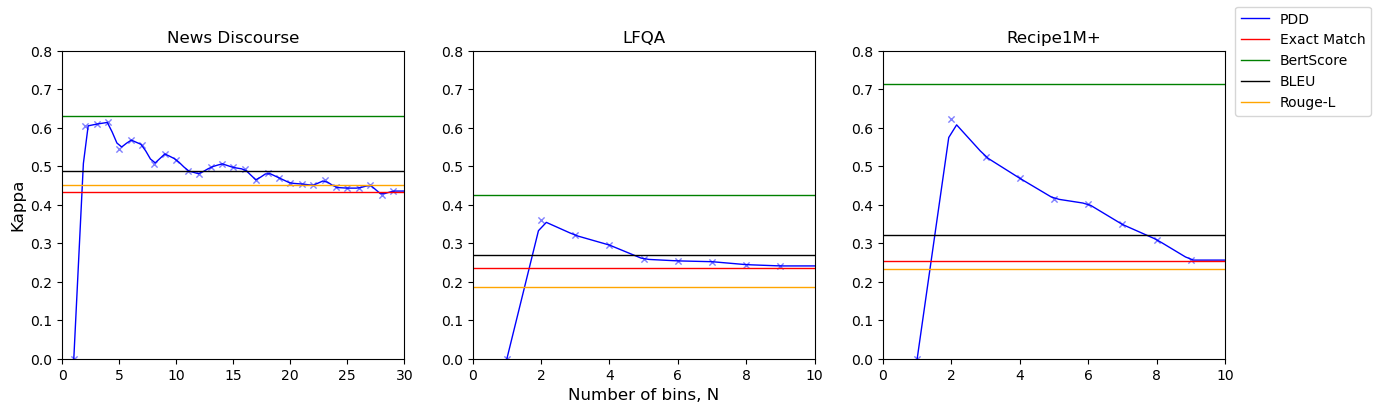

In [43]:
import matplotlib.pyplot as plt
import numpy as np

fig, axs = plt.subplots(1, 3, figsize=(15, 4))
ylim = [0, 0.8]

#---------------------- NEWS -----------------------------------
N=30

x = np.array(range(1,N))
y = np.array(news_pd_kappa_list) 
# y[0]=0.001

smooth_x = np.linspace(1, N, 70)  # Adjust the range and number of points as needed
smooth_y = np.interp(smooth_x, x, y)  # Use interpolation to get smooth values


axs[0].scatter(x, y, marker='x', color='blue', alpha=0.5, s=20, lw=1)
axs[0].plot(smooth_x, smooth_y, color='blue', lw=1)
axs[0].axhline(y=news_acc_corr, color='r', linestyle='-', lw=1)
axs[0].axhline(y=news_bertscore_kappa, color='g', linestyle='-', lw=1)
axs[0].axhline(y=news_bleu_kappa, color='black', linestyle='-', lw=1)
axs[0].axhline(y=news_rouge_kappa, color='orange', linestyle='-', lw=1)
axs[0].set_ylim(ylim)
axs[0].set_xlim([0, N])
axs[0].set_title('News Discourse', fontsize=12)
axs[0].set_ylabel("Kappa", fontsize=12)

#------------------------- LFQA --------------------------------
N=10
x = np.array(range(1,N))
y = np.array(lfqa_pd_kappa_list)
# y[0]=0.001

smooth_x = np.linspace(1, N, 40)  # Adjust the range and number of points as needed
smooth_y = np.interp(smooth_x, x, y)  # Use interpolation to get smooth values


axs[1].scatter(x, y, marker='x', color='blue', alpha=0.5, s=20, lw=1)
axs[1].plot(smooth_x, smooth_y, color='blue', lw=1)
axs[1].axhline(y=lfqa_acc_corr, color='r', linestyle='-', lw=1)
axs[1].axhline(y=lfqa_bertscore_kappa, color='g', linestyle='-', lw=1)
axs[1].axhline(y=lfqa_bleu_kappa-0.05, color='black', linestyle='-', lw=1)
axs[1].axhline(y=lfqa_rouge_kappa, color='orange', linestyle='-', lw=1)
axs[1].set_ylim(ylim)
axs[1].set_xlim([0, N])
axs[1].set_title('LFQA', fontsize=12)
axs[1].set_xlabel('Number of bins, N', fontsize=12)

#------------------------- RECIPES --------------------------------
N=10
x = np.array(range(1,N))
y = np.array(recipe_pd_kappa_list)

smooth_x = np.linspace(1, N, 40)  # Adjust the range and number of points as needed
smooth_y = np.interp(smooth_x, x, y)  # Use interpolation to get smooth values

axs[2].scatter(x, y, marker='x', color='blue', alpha=0.5, s=20, lw=1)
axs[2].plot(smooth_x, smooth_y, label='PDD', color='blue', lw=1)
axs[2].axhline(y=recipe_acc_corr, color='r', label='Exact Match', linestyle='-', lw=1)
axs[2].axhline(y=recipe_bertscore_kappa, color='g', label='BertScore', linestyle='-', lw=1)
axs[2].axhline(y=recipe_bleu_kappa, color='black', label='BLEU', linestyle='-', lw=1)
axs[2].axhline(y=recipe_rouge_kappa, color='orange', label='Rouge-L', linestyle='-', lw=1)
axs[2].set_ylim(ylim)
axs[2].set_xlim([0, N])
axs[2].set_title('Recipe1M+', fontsize=12)

fig.legend(loc='upper right')
fig.savefig('kappa.pdf', bbox_inches='tight')

